In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [65]:
# build the dataset
block_size = 5 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 5]) torch.Size([182580])
torch.Size([22767, 5]) torch.Size([22767])
torch.Size([22799, 5]) torch.Size([22799])


In [10]:
C = torch.randn((27, 2))

In [11]:
print((16.90 * 2) + (1.74 * 2))

37.279999999999994


In [12]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [13]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [14]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [15]:
h

tensor([[-0.9920, -0.0900, -0.5295,  ...,  0.6988,  0.9969, -0.5570],
        [-1.0000,  0.3164, -0.0431,  ..., -0.2440,  0.9997,  0.9248],
        [-0.9995, -0.0438,  0.2985,  ..., -0.9014, -0.9993,  0.7151],
        ...,
        [-0.8681, -0.0774,  0.2873,  ...,  0.9996, -0.9148, -0.9837],
        [-0.9971,  0.9645, -0.9007,  ...,  0.9920,  0.9971, -0.5288],
        [-1.0000,  0.7109,  0.9719,  ...,  0.5183, -0.3131, -0.9034]])

In [16]:
h.shape

torch.Size([228146, 100])

In [17]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [18]:
logits = h @ W2 + b2

In [19]:
logits.shape

torch.Size([228146, 27])

In [20]:
counts = logits.exp()

In [21]:
prob = counts / counts.sum(1, keepdims=True)

In [22]:
prob.shape

torch.Size([228146, 27])

In [24]:
# ------------ now made respectable :) ---------------

In [68]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 5]), torch.Size([182580]))

In [69]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((50, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [70]:
sum(p.nelement() for p in parameters) # number of parameters in total

23697

In [71]:
for p in parameters:
  p.requires_grad = True

In [72]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [73]:
lri = []
lossi = []
stepi = []

In [79]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 5, 10)
  h = torch.tanh(emb.view(-1, 50) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  # lr = 0.1 if i < 100000 else 0.01
  lr = 0.005

  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

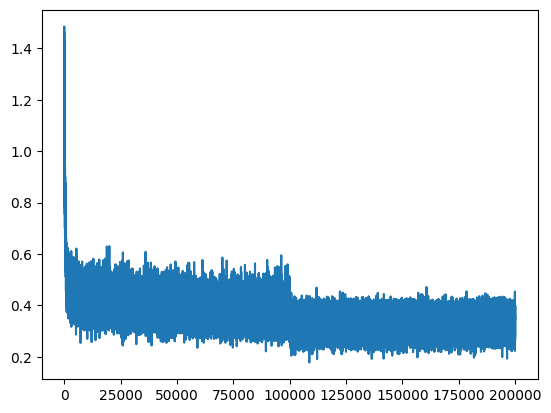

In [75]:
plt.plot(stepi, lossi)

In [80]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 50) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1365, grad_fn=<NllLossBackward0>)

In [81]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 50) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1603, grad_fn=<NllLossBackward0>)

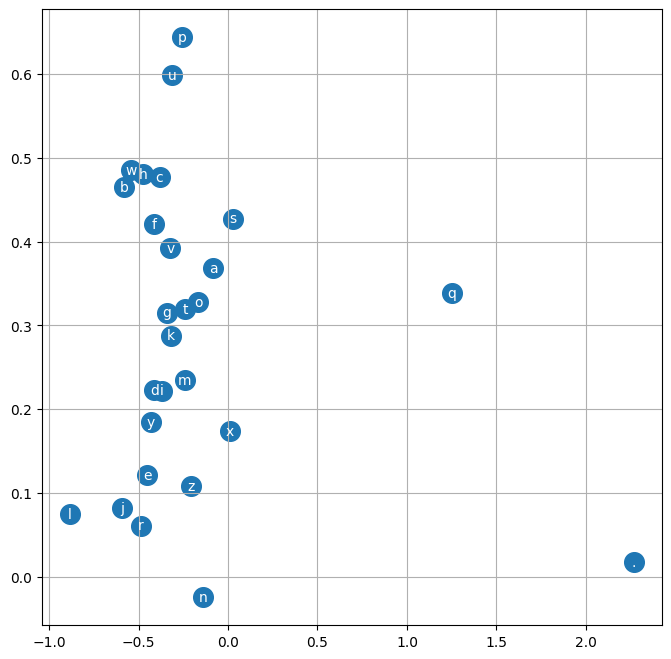

In [82]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

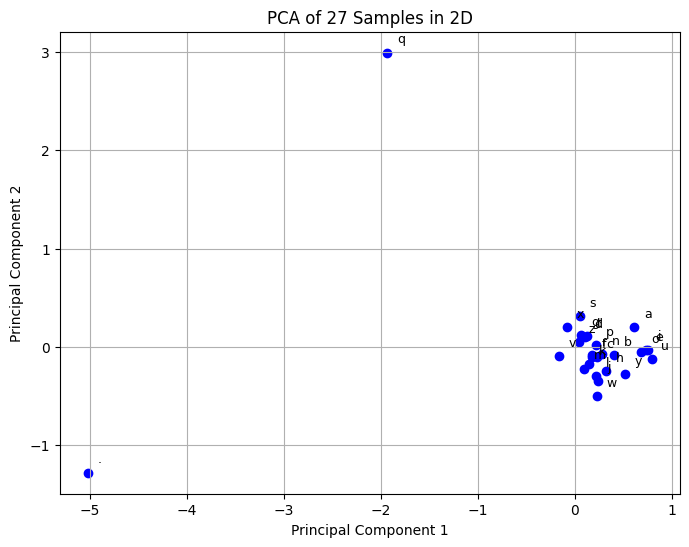

In [84]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Sample torch tensor with 27 samples and 10 dimensions
data = C  # Replace with your tensor

# Convert torch tensor to numpy array for PCA
data_numpy = data.detach().numpy()

# Apply PCA to reduce the dimensionality from 10D to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_numpy)

# Plot the 2D PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', marker='o')

# Annotate each point with its sample index
for i in range(len(pca_result)):
    plt.text(pca_result[i, 0] + 0.1, pca_result[i, 1] + 0.1, itos[i], fontsize=9)

plt.title('PCA of 27 Samples in 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [85]:
C.shape

torch.Size([27, 10])

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [63]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [86]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

morail.
yazziel.
madhah.
lorethrettadrlee.
adere.
seliah.
mioren.
edelina.
anara.
pyzim.
marain.
shubergahimiel.
kinir.
jelionnterofi.
brenddi.
jamell.
ehsylay.
mastey.
azhia.
salyah.
